# **Identifying groups of inequality and children mortality: clustering problem**

Description of the problem

All over the world, the children are the most vulnerable piece of societies. Even in developed countrys, the children doesn't recieve the help of masive incomes produced by industries, and exportations. Using this dataset, we want to identify wich countrys  have more difference between their economy, and the child mortality. This could be an indicator of the inequality towards children. Our hipothesis is that there will be some countrys that even with a poor economic development, the child mortality will be low, and there will be countrys with a powerful economic system, that will have high Child mortality in comparission with their incomes. 

For this work we will use a Dataset of HELP, an humanitarian NGO, but  we will produce our own country qualifiers.



# Step 1: Ingest and make some aproaches to the Data

We first have to ingest, and make some aproaches to the data, in order to see relations and statistical information about them.

In [1]:
# import all libraries and dependencies for dataframe

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import all libraries and dependencies for data visualization
pd.options.display.float_format='{:.4f}'.format
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 0) 
sns.set(style='darkgrid')
import matplotlib.ticker as plticker
%matplotlib inline

# import all libraries and dependencies for machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

# import all libraries and dependencies for clustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

print('Libraries load finished')

Libraries load finished


In [2]:
#First we read the data and load it to a pandas dataframe.
df = pd.read_csv('../input/pca-kmeans-hierarchical-clustering/Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2000,10.0000,7.5800,44.9000,1610,9.4400,56.2000,5.8200,553
1,Albania,16.6000,28.0000,6.5500,48.6000,9930,4.4900,76.3000,1.6500,4090
2,Algeria,27.3000,38.4000,4.1700,31.4000,12900,16.1000,76.5000,2.8900,4460
3,Angola,119.0000,62.3000,2.8500,42.9000,5900,22.4000,60.1000,6.1600,3530
4,Antigua and Barbuda,10.3000,45.5000,6.0300,58.9000,19100,1.4400,76.8000,2.1300,12200


In [3]:
#Let's see the types of the data in the dataset
df.dtypes

country       object 
child_mort    float64
exports       float64
health        float64
imports       float64
income        int64  
inflation     float64
life_expec    float64
total_fer     float64
gdpp          int64  
dtype: object

We are lucky to have a Data dictionary related to this Dataset.

In [4]:
dd = pd.read_csv('../input/pca-kmeans-hierarchical-clustering/data-dictionary.csv')
dd.head(10)

,Column Name,Description
0,country,Name of the country
1,child_mort,Death of children under 5 years of age per 1000 live births
2,exports,Exports of goods and services. Given as %age of the Total GDP
3,health,Total health spending as %age of Total GDP
4,imports,Imports of goods and services. Given as %age of the Total GDP
5,Income,Net income per person
6,Inflation,The measurement of the annual growth rate of the Total GDP
7,life_expec,The average number of years a new born child would live if the current mortality patterns are to remain the same
8,total_fer,The number of children that would be born to each woman if the current age-fertility rates remain the same.
9,gdpp,The GDP per capita. Calculated as the Total GDP divided by the total population.


In [5]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000,167.0000
mean,38.2701,41.1090,6.8157,46.8902,17144.6886,7.7818,70.5557,2.9480,12964.1557
std,40.3289,27.4120,2.7468,24.2096,19278.0677,10.5707,8.8932,1.5138,18328.7048
min,2.6000,0.1090,1.8100,0.0659,609.0000,-4.2100,32.1000,1.1500,231.0000
25%,8.2500,23.8000,4.9200,30.2000,3355.0000,1.8100,65.3000,1.7950,1330.0000
50%,19.3000,35.0000,6.3200,43.3000,9960.0000,5.3900,73.1000,2.4100,4660.0000
75%,62.1000,51.3500,8.6000,58.7500,22800.0000,10.7500,76.8000,3.8800,14050.0000
max,208.0000,200.0000,17.9000,174.0000,125000.0000,104.0000,82.8000,7.4900,105000.0000


The pair plot could show us some correlations between features,and find good candidates for our indicator.

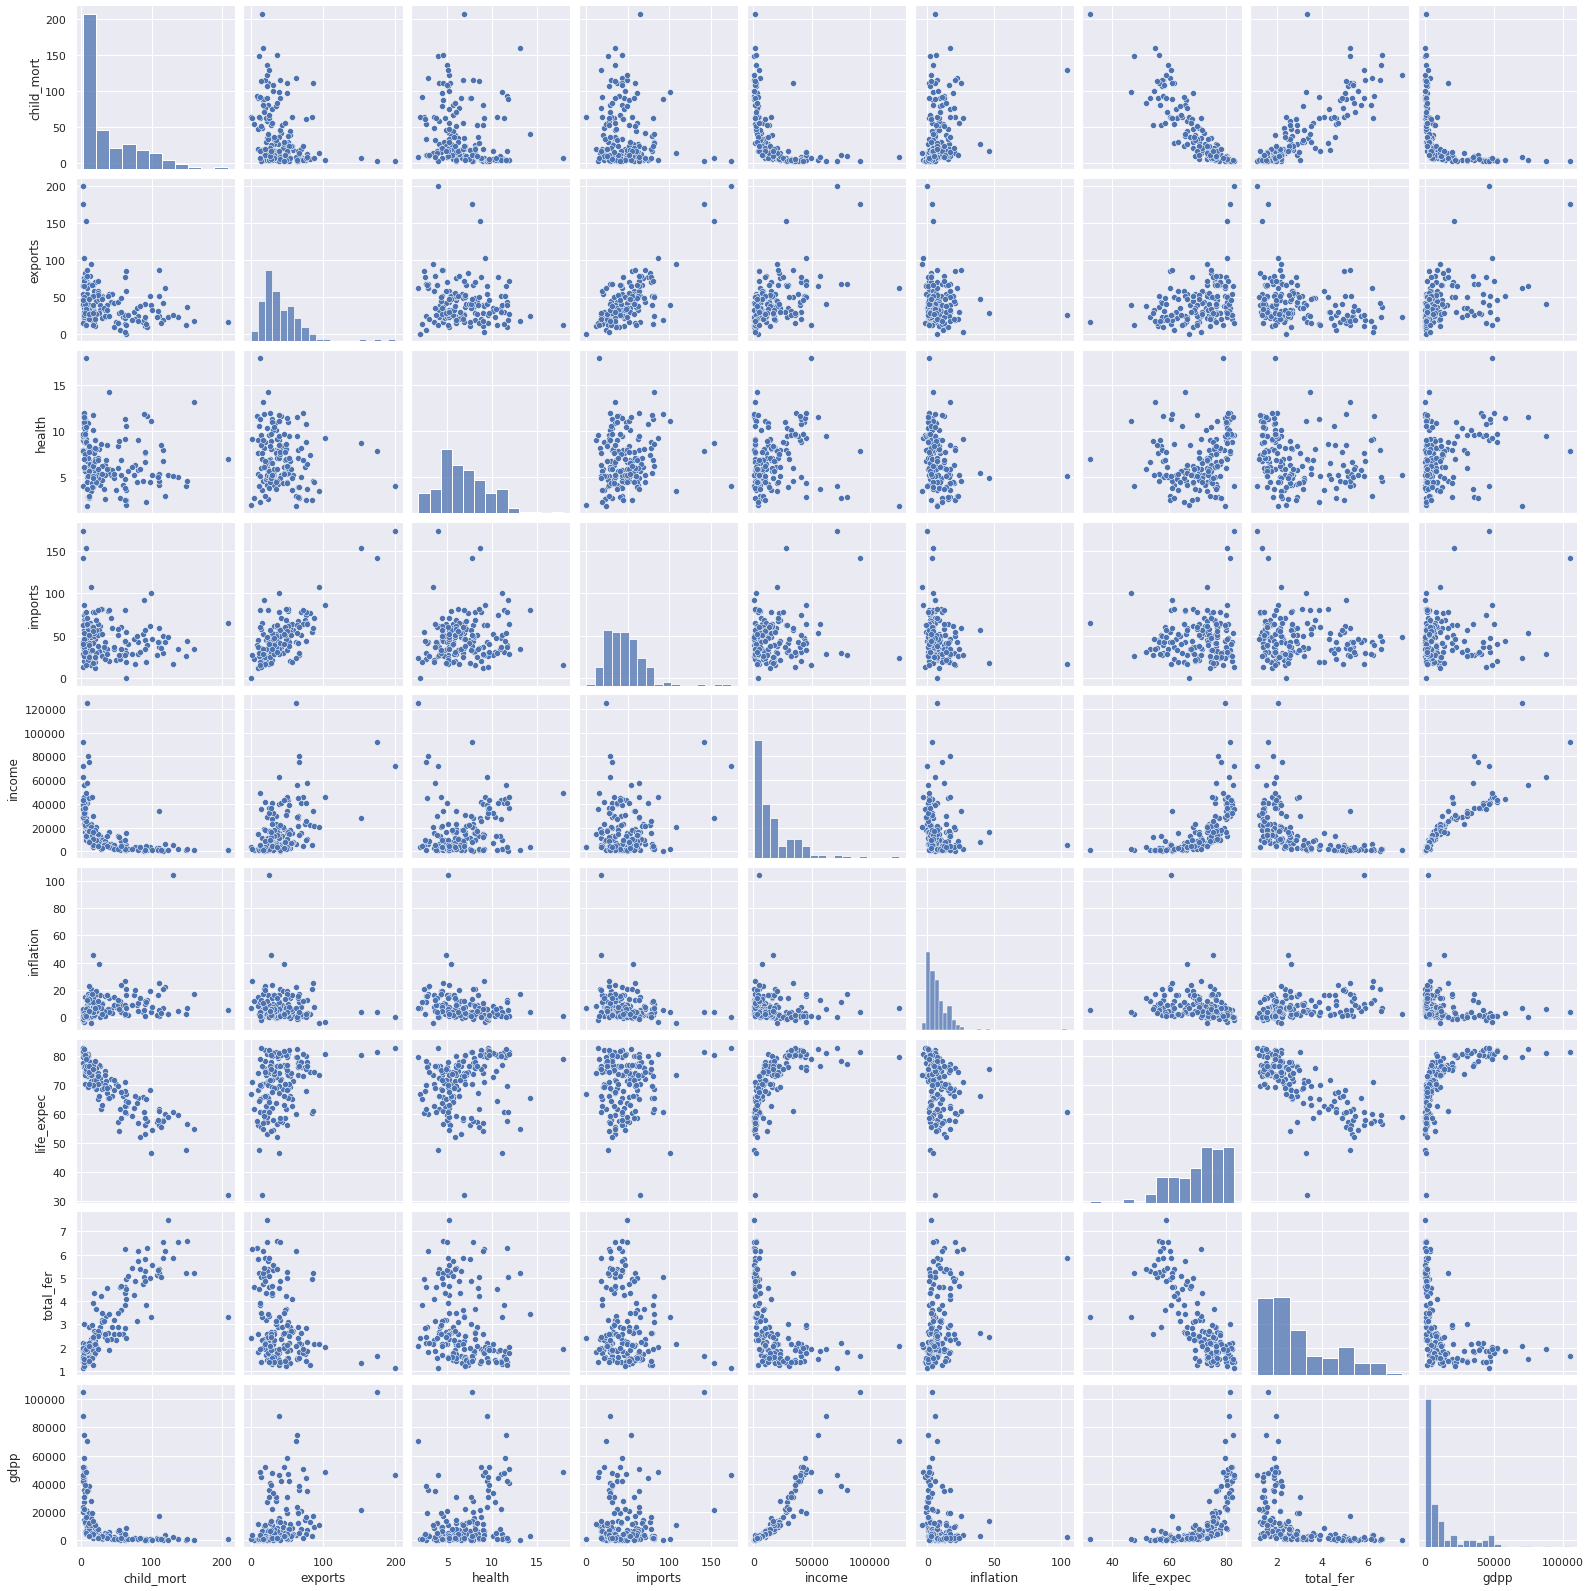

In [6]:
sns.pairplot(df)

Reading the pair-lot we could find two almost linear relationships:

1)child_mort - total_fer : implies that a there is a relation between newborns per female, and child deaths.
2)gdpp-income : This one is pretty obvius, and it's not of our concern.

One relationship that is of our interest is gdpp-child_mort

Also we see that gdpp (It's obvious, isn't it?) is very concentrated in a few countrys.

Let's see the map of correlation between the data, to put numerical values to our asumptions.

(9.5, -0.5)

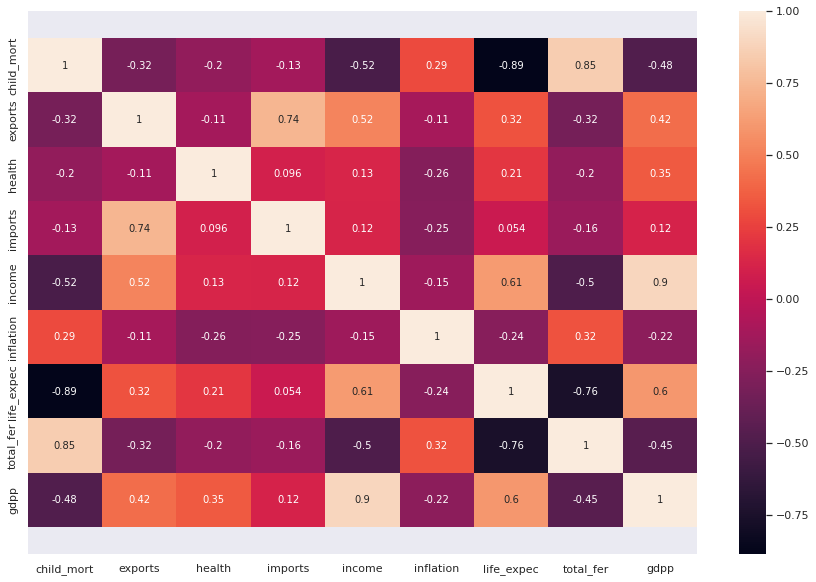

In [7]:
plt.figure(figsize = (15,10))        
ax = sns.heatmap(df.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Setep 2: Data preparation and feature engineering
We found good relationships, but we have to do some data preparation to optimize the processing and sclate data.

**Feature Engeneering**

Is of our interest to evaluate the relationship between child deaths and the income. We have to create an index to asociate this two factors. We will make a multiplication between deaths, and GDPP. A small number represents a good position, but a big number it could be a distribution problem.

In [8]:
#The "Health" are a percent of the gdpp. In this format make irrelevant numbers. We will transform them in absolute values.
df['health'] = df['health'] * df['gdpp']/100

In [9]:
#Imports and exports, are data that could make some noise in our analysis, so we will drop them.
df.drop('imports',axis='columns', inplace=True)
df.drop('exports',axis='columns', inplace=True)


In [10]:
#Firs't we have to replace all 0 with a 0.01 to avoid noise in the data, but still with the objetive to low the value.

df['child_mort'] = df['child_mort'].replace(0,0.001)

#Next we will create a new column with this data
df['Cp3Index'] = df['child_mort']*df['gdpp']
df.sort_values(by="Cp3Index",ascending=False,kind="mergesort")

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Cp3Index
49,Equatorial Guinea,111.0000,766.0800,33700,24.9000,60.9000,5.2100,17100,1898100.0000
123,Qatar,9.0000,1272.4300,125000,6.9800,79.5000,2.0700,70300,632700.0000
55,Gabon,63.7000,306.2500,15400,16.6000,62.9000,4.0800,8750,557375.0000
3,Angola,119.0000,100.6050,5900,22.4000,60.1000,6.1600,3530,420070.0000
82,Kuwait,10.8000,1012.5500,75200,11.2000,78.2000,2.2100,38500,415800.0000
...,...,...,...,...,...,...,...,...,...
109,Nepal,47.0000,31.0800,1990,15.1000,68.3000,2.6100,592,27824.0000
50,Eritrea,55.2000,12.8212,1420,11.6000,61.7000,4.6100,482,26606.4000
83,Kyrgyz Republic,29.6000,54.3840,2790,10.0000,68.5000,3.1000,880,26048.0000
93,Madagascar,62.2000,15.5701,1390,8.7900,60.8000,4.6000,413,25688.6000


Well, this starts to be some information. It could be moral arguably, that in the bottom of the table we have some countrys with almost a hundred in the "child_mort" feature, but as we explained, the goal of our research is to find countrys with a High income, but still have child mortality. 

Let's plot the structure of this new feature.

<AxesSubplot:>

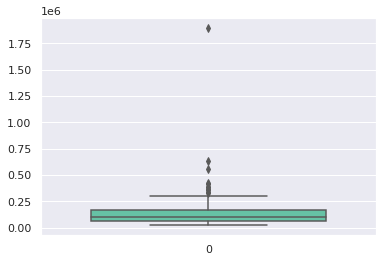

In [11]:
sns.boxplot(data = df['Cp3Index'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)

Well we have an extreme outlayer: "Equiatorial Guinea". In this case, we will erase this record, not because it's an "error". It's very probably that socio-cultural problems in this country make this happen in the real world, but to analyze the rest of the dataset and, obtain a more "handeable" data.

<AxesSubplot:>

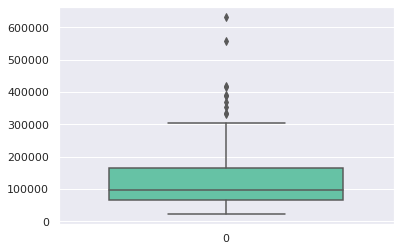

In [12]:
df.drop(df[df.country=='Equatorial Guinea'].index, inplace=True)
sns.boxplot(data = df['Cp3Index'], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)

<AxesSubplot:xlabel='gdpp', ylabel='Cp3Index'>

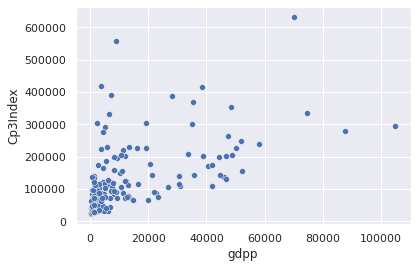

In [13]:
sns.scatterplot(data=df,x="gdpp",y="Cp3Index")

In [14]:
from sklearn.preprocessing import StandardScaler
stScaler = StandardScaler()
df_country_drop = df.copy()
#To fit the model, we will drop gdpp witch is already is infered in our new index, income, that has a linear relationship with it,
#total_fer, life_spec
df_country_drop.drop('gdpp',axis='columns', inplace=True)
df_country_drop.drop('income',axis='columns', inplace=True)
df_country_drop.drop('total_fer',axis='columns', inplace=True)
df_country_drop.drop('life_expec',axis='columns', inplace=True)
country = df_country_drop.pop('country')

df_Scaled = pd.DataFrame(stScaler.fit_transform(df_country_drop))
df_Scaled.describe()


,0,1,2,3
count,166.0000,166.0000,166.0000,166.0000
mean,0.0000,-0.0000,0.0000,-0.0000
std,1.0030,1.0030,1.0030,1.0030
min,-0.8824,-0.5805,-1.1337,-1.0730
25%,-0.7452,-0.5445,-0.5616,-0.6291
50%,-0.4654,-0.4133,-0.2302,-0.3371
75%,0.5852,-0.0406,0.2667,0.3315
max,4.2617,4.2221,9.1854,4.9411


# Step 3: Create model

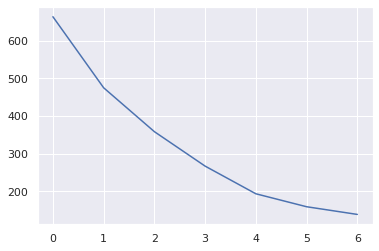

In [15]:
#We will use K-Means to cluster our Data, so, we have to find an optimal quantity of clusters. 
#We will use the elbow technique to do so.
ssd = []
for num_clusters in list(range(1,8)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50,random_state= 100)
    model_clus.fit(df_Scaled)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)


It seems thar 4 clusters will do ok.

In [16]:
cluster4 = KMeans(n_clusters=4)
cluster4.fit(df_Scaled)


KMeans(n_clusters=4)

In [17]:
df['Clusters'] = cluster4.labels_

<AxesSubplot:xlabel='gdpp', ylabel='child_mort'>

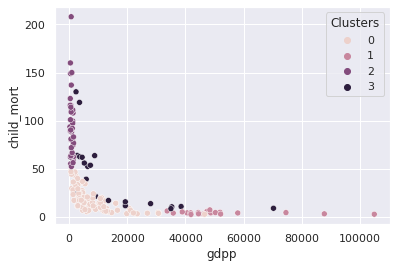

In [18]:
sns.scatterplot(data=df,x="gdpp",y="child_mort",hue="Clusters")

In this escenario we have 4 groups, wich could be named this way:
* 1 = Average countries, with less than 50 child deaths, but low gdpp
* 3 = Poor countries with high child mortality rate, but very low gdpp
* 2 = High gdpp countries but very low child deaths
* 0 = The group of our interest. Countries with really inequal situations between income and child mortality

Let's try other types of clustering. 

<AxesSubplot:xlabel='gdpp', ylabel='child_mort'>

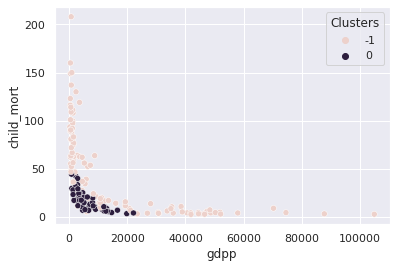

In [19]:
#DBSCAN
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.50, min_samples=15)
# fit model and predict clusters
yhat = model.fit_predict(df_Scaled)
df['Clusters'] = yhat
sns.scatterplot(data=df,x="gdpp",y="child_mort",hue="Clusters")

<AxesSubplot:xlabel='gdpp', ylabel='child_mort'>

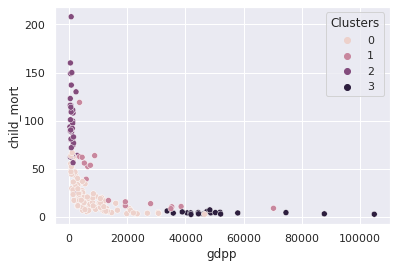

In [20]:
from sklearn.cluster import MiniBatchKMeans
model = MiniBatchKMeans(n_clusters=4)
yhat = model.fit_predict(df_Scaled)
df['Clusters'] = yhat
sns.scatterplot(data=df,x="gdpp",y="child_mort",hue="Clusters")

This a more accurate model.

In this escenario we have 4 groups, wich could be named this way:
* 0 = Average countries, with less than 50 child deaths, but low gdpp
* 1 = Poor countries with high child mortality rate, but very low gdpp
* 2 = High gdpp countries but very low child deaths
* 3 = The group of our interest. Countries with really inequal situations between income and child mortality

Let's see this lists of countries

In [21]:
#This is could be the group first to talk about child mortality and income.
df[df.Clusters==3].sort_values(by="Cp3Index",ascending=False,kind="mergesort")

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Cp3Index,Clusters
159,United States,7.3000,8663.6000,49400,1.2200,78.7000,1.9300,48400,353320.0000,3
145,Switzerland,4.5000,8579.0000,55500,0.3170,82.2000,1.5200,74600,335700.0000,3
91,Luxembourg,2.8000,8158.5000,91700,3.6200,81.3000,1.6300,105000,294000.0000,3
114,Norway,3.2000,8323.4400,62300,5.9500,81.0000,1.9500,87800,280960.0000,3
29,Canada,5.6000,5356.2000,40700,2.8700,81.3000,1.6300,47400,265440.0000,3
7,Australia,4.8000,4530.8700,41400,1.1600,82.0000,1.9300,51900,249120.0000,3
44,Denmark,4.1000,6612.0000,44000,3.2200,79.5000,1.8700,58000,237800.0000,3
110,Netherlands,4.5000,5985.7000,45500,0.8480,80.7000,1.7900,50300,226350.0000,3
111,New Zealand,6.2000,3403.7000,32300,3.7300,80.9000,2.1700,33700,208940.0000,3
73,Ireland,4.2000,4475.5300,45700,-3.2200,80.4000,2.0500,48700,204540.0000,3


In [22]:
#This is the group with very high GDPP, and low mortality rates
df[df.Clusters==2].sort_values(by="Cp3Index",ascending=False,kind="mergesort")

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Cp3Index,Clusters
113,Nigeria,130.0000,118.1310,5150,104.0000,60.5000,5.8400,2330,302900.0000,2
38,"Congo, Rep.",63.9000,67.4040,5190,20.7000,60.4000,4.9500,2740,175086.0000,2
28,Cameroon,108.0000,67.2030,2660,1.9100,57.3000,5.1100,1310,141480.0000,2
66,Haiti,208.0000,45.7442,1500,5.4500,32.1000,3.3300,662,137696.0000,2
40,Cote d'Ivoire,111.0000,64.6600,2690,5.3900,56.3000,5.2700,1220,135420.0000,2
32,Chad,150.0000,40.6341,1930,6.3900,56.5000,6.5900,897,134550.0000,2
166,Zambia,83.1000,85.9940,3280,14.0000,52.0000,5.4000,1460,121326.0000,2
99,Mauritania,97.4000,52.9200,3320,18.9000,68.2000,4.9800,1200,116880.0000,2
87,Lesotho,99.7000,129.8700,2380,4.1500,46.5000,3.3000,1170,116649.0000,2
142,Sudan,76.7000,93.5360,3370,19.6000,66.3000,4.8800,1480,113516.0000,2


In [23]:
#This is the average countries group. The median regarding child_mort is 19.8, and GDPP is 4660
df[df.Clusters==0].sort_values(by="Cp3Index",ascending=False,kind="mergesort")

,country,child_mort,health,income,inflation,life_expec,total_fer,gdpp,Cp3Index,Clusters
13,Barbados,14.2000,1275.2000,15300,0.3210,76.7000,1.7800,16000,227200.0000,0
22,Brazil,19.8000,1009.1200,14500,8.4100,74.2000,1.8000,11200,221760.0000,0
153,Turkey,19.1000,721.1800,18000,7.0100,78.2000,2.1500,10700,204370.0000,0
89,Libya,16.6000,469.4800,29600,14.2000,76.1000,2.4100,12100,200860.0000,0
143,Suriname,24.1000,581.8300,14200,7.2000,70.3000,2.5200,8300,200030.0000,0
...,...,...,...,...,...,...,...,...,...,...
164,Vietnam,23.3000,89.6040,4490,12.1000,73.1000,1.9500,1310,30523.0000,0
102,Moldova,17.2000,190.7100,3910,11.1000,69.7000,1.2700,1630,28036.0000,0
109,Nepal,47.0000,31.0800,1990,15.1000,68.3000,2.6100,592,27824.0000,0
50,Eritrea,55.2000,12.8212,1420,11.6000,61.7000,4.6100,482,26606.4000,0


# Final words

This notebook is using pre-pandemic Data, and it's for educational purposes, but it's a close escenario of the world situation, where the GAP of incomes between the society have a deep impact in child well-being. UNICEF had done a great job addressing this problem in this link, for the UE: https://www.unicef-irc.org/publications/830-fairness-for-children-a-league-table-of-inequality-in-child-well-being-in-rich-countries.html
